# Bayesian Linear Regression Fitter

This notebook aims to perform a Bayesian linear regression on simple data which are assumed to be linearly dependant.

Before performing our Bayesian analysis, to improve computation time we perform a **simple least squares** regression to help inform our decision on our priors. 

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
import random

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def linear_least_squares(X,Y):
    if len(X) == len(Y):
        
        N = len(X)
        sum_xy = np.sum(X*Y)
        sum_x = np.sum(X)
        sum_y = np.sum(Y)
        sum_x2 = np.sum(X**2)

        m = (N * sum_xy - sum_x * sum_y)/(N * sum_x2 - (sum_x)**2)
        b = (sum_y - m * sum_x)/N

        return m, b
    
    else:
        return print('Error: Dimension mismatch between X and Y')

In [3]:
def calculate_sample_size(len_X, base_size=1000, base_len=50):
    """
    Calculate the number of samples for MCMC based on the length of the dataset.
    :param len_X: Length of the dataset.
    :param base_size: Base number of samples for the base length of the dataset.
    :param base_len: The dataset length for which the base size is defined.
    :return: Calculated number of samples.
    """
    if len_X >= base_len:
        return base_size
    else:
        # Increase the number of samples for smaller datasets
        return int(base_size * (base_len / len_X))

In [4]:
def bayesian_linear_regression(X, Y, m, b): # --> X,Y are the data, m,b are the priors  
    
    num_samples = calculate_sample_size(len(X))

    with pm.Model() as linear_model:
        # Priors for unknown model parameters
        alpha = pm.Normal('alpha', mu=b, sigma=20)
        beta = pm.Normal('beta', mu=m, sigma=20)
        sigma = pm.HalfNormal('sigma', sd=1)

        # Expected value of outcome (linear model)
        mu = alpha + beta * X

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

        trace = pm.sample(num_samples)

        ppc = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])

        # Calculate the mean prediction and the interval for each X
        pred_means = np.mean(ppc['Y_obs'], axis=0)
        pred_intervals = np.percentile(ppc['Y_obs'], [2.5, 97.5], axis=0)

    return trace, pred_means, pred_intervals

In [5]:
def plot_trace(X, Y, trace, save=False):
    pm.plot_trace(trace)
    
    alpha_mean = np.mean(trace['alpha'])
    beta_mean = np.mean(trace['beta'])
    sigma_mean = np.mean(trace['sigma'])

    alpha_error = trace['alpha'].std()
    beta_error = trace['beta'].std()
    sigma_error = trace['sigma'].std()

    textstr = '\n'.join((
        f'Mean Alpha = {alpha_mean:.3f} +/- {alpha_error:.3f}',
        f'Mean Beta = {beta_mean:.3f} +/- {beta_error:.3f}',
        f'Mean Sigma = {sigma_mean:.3f} +/- {sigma_error:.3f}'))

    plt.gcf().text(0.15, 0.85, textstr, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    if save:
        plt.savefig('trace_plot.png')
    plt.show()

In [6]:
def plot_results(X, Y, trace, pred_means, pred_intervals, save=False):
    # Sort X and rearrange Y, pred_means, and pred_intervals accordingly
    sorted_indices = np.argsort(X)
    X_sorted = X[sorted_indices]
    Y_sorted = Y[sorted_indices]
    pred_means_sorted = pred_means[sorted_indices]
    pred_intervals_sorted = pred_intervals[:, sorted_indices]

    plt.figure(figsize=(8, 5))
    plt.scatter(X_sorted, Y_sorted, c='blue', label='Data', marker='.', zorder=99)
    plt.plot(X_sorted, pred_means_sorted, c='red', label='Mean Prediction')
    plt.fill_between(X_sorted, pred_intervals_sorted[0, :], pred_intervals_sorted[1, :], color='red', alpha=0.3, label='95% Prediction Interval')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bayesian Linear Regression with Uncertainty')
    plt.legend()

    if save:
        plt.savefig('regression_plot.png')
    plt.show()

In [7]:
# Choose the "true" parameters --> thick grey line in graph.
m_true = random.randrange(-100,100)
b_true = random.randrange(-100,100)
f_true = random.randrange(2,10) # --> determines how spread our fake data is

# Generate some synthetic data from the model.
N = 5
X = np.array(range(N)) 
yerr = 0.5 + 5 * np.random.rand(N) # --> random error values for data
y_true = m_true * X + b_true # --> the value which our data will be spread about

Y = np.random.normal(loc=y_true, scale=yerr*f_true, size=N) 

print(m_true, b_true, f_true)

-31 -18 7


In [8]:
m, b = linear_least_squares(X,Y)

print(m,b)

-29.12483686362769 -14.468398082428052


In [9]:
trace, pred_means, pred_intervals = bayesian_linear_regression(X,Y,m,b)

/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences afte

/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


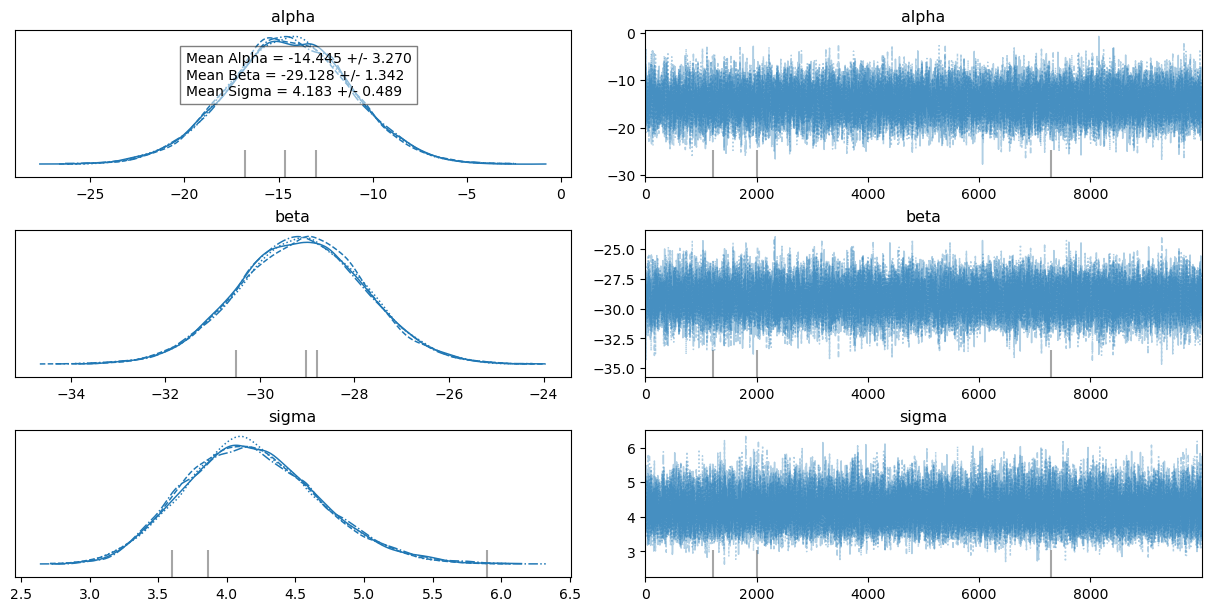

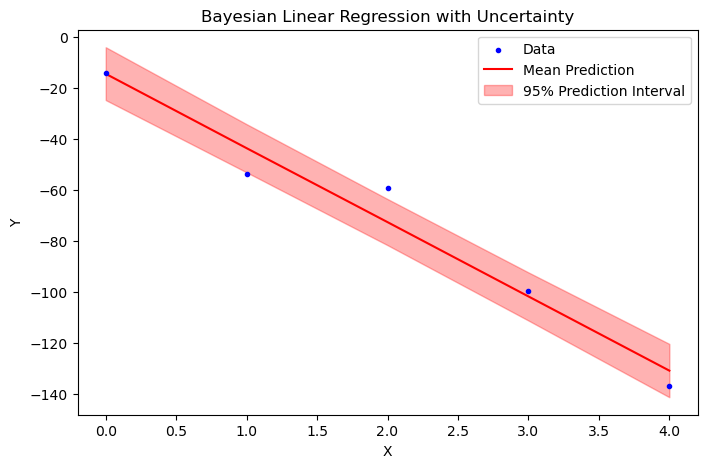

In [10]:
plot_trace(X,Y,trace)
plot_results(X, Y, trace, pred_means, pred_intervals)